In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
from time import time
from tqdm import tqdm_notebook as tqdm
from collections import Counter
from scipy import stats
import lightgbm as lgb
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit, RepeatedStratifiedKFold
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import kurtosis, skew
import matplotlib.pyplot as plt
import gc
import json
import copy
import time
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import seaborn as sns

from pathlib import Path
import sys
import re

In [3]:
path=Path('/kaggle/data_science_bowl')
path

PosixPath('/kaggle/data_science_bowl')

In [4]:
def read_data():
    train_df = pd.read_csv(path/'train.csv')
    test_df = pd.read_csv(path/'test.csv')
    train_labels_df = pd.read_csv(path/'train_labels.csv')
    specs_df = pd.read_csv(path/'specs.csv')
    return train_df, test_df, train_labels_df, specs_df

In [5]:
%%time
train_df, test_df, train_labels_df, specs_df = read_data()

In [6]:
def encode_title(train, test, train_labels):
    # encode title
    train['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), train['title'], train['event_code']))
    test['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), test['title'], test['event_code']))
    all_title_event_code = list(set(train["title_event_code"].unique()).union(test["title_event_code"].unique()))
    # make a list with all the unique 'titles' from the train and test set
    list_of_user_activities = list(set(train['title'].unique()).union(set(test['title'].unique())))
    # make a list with all the unique 'event_code' from the train and test set
    list_of_event_code = list(set(train['event_code'].unique()).union(set(test['event_code'].unique())))
    list_of_event_id = list(set(train['event_id'].unique()).union(set(test['event_id'].unique())))
    # make a list with all the unique worlds from the train and test set
    list_of_worlds = list(set(train['world'].unique()).union(set(test['world'].unique())))
    # create a dictionary numerating the titles
    activities_map = dict(zip(list_of_user_activities, np.arange(len(list_of_user_activities))))
    activities_labels = dict(zip(np.arange(len(list_of_user_activities)), list_of_user_activities))
    activities_world = dict(zip(list_of_worlds, np.arange(len(list_of_worlds))))
    assess_titles = list(set(train[train['type'] == 'Assessment']['title'].value_counts().index).union(set(test[test['type'] == 'Assessment']['title'].value_counts().index)))
    # replace the text titles with the number titles from the dict
    train['title'] = train['title'].map(activities_map)
    test['title'] = test['title'].map(activities_map)
    train['world'] = train['world'].map(activities_world)
    test['world'] = test['world'].map(activities_world)
    train_labels['title'] = train_labels['title'].map(activities_map)
    win_code = dict(zip(activities_map.values(), (4100*np.ones(len(activities_map))).astype('int')))
    # then, it set one element, the 'Bird Measurer (Assessment)' as 4110, 10 more than the rest
    win_code[activities_map['Bird Measurer (Assessment)']] = 4110
    # convert text into datetime
    train['timestamp'] = pd.to_datetime(train['timestamp'])
    test['timestamp'] = pd.to_datetime(test['timestamp'])
    
    
    return train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code

In [7]:
train_df, test_df, train_labels_df, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code = \
encode_title(train_df, test_df, train_labels_df)

In [8]:
def get_data(user_sample, test_set=False):
    '''
    The user_sample is a DataFrame from train or test where the only one 
    installation_id is filtered
    And the test_set parameter is related with the labels processing, that is only requered
    if test_set=False
    '''
    # Constants and parameters declaration
    last_activity = 0
    
    user_activities_count = {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
    
    # new features: time spent in each activity
    last_session_time_sec = 0
    accuracy_groups = {0:0, 1:0, 2:0, 3:0}
    all_assessments = []
    accumulated_accuracy_group = 0
    accumulated_accuracy = 0
    accumulated_correct_attempts = 0 
    accumulated_uncorrect_attempts = 0
    accumulated_actions = 0
    counter = 0
    durations = []
    last_accuracy_title = {'acc_' + title: -1 for title in assess_titles}
    event_code_count: Dict[str, int] = {ev: 0 for ev in list_of_event_code}
    event_id_count: Dict[str, int] = {eve: 0 for eve in list_of_event_id}
    title_count: Dict[str, int] = {eve: 0 for eve in activities_labels.values()} 
    title_event_code_count: Dict[str, int] = {t_eve: 0 for t_eve in all_title_event_code}
    
    # itarates through each session of one instalation_id
    for i, session in user_sample.groupby('game_session', sort=False):
        # i = game_session_id
        # session is a DataFrame that contain only one game_session
        
        # get some sessions information
        session_type = session['type'].iloc[0]
        session_title = session['title'].iloc[0]
        session_title_text = activities_labels[session_title]
                    
            
        # for each assessment, and only this kind off session, the features below are processed
        # and a register are generated
        if (session_type == 'Assessment') & (test_set or len(session)>1):
            # search for event_code 4100, that represents the assessments trial
            all_attempts = session.query(f'event_code == {win_code[session_title]}')
            # then, check the numbers of wins and the number of losses
            true_attempts = all_attempts['event_data'].str.contains('true').sum()
            false_attempts = all_attempts['event_data'].str.contains('false').sum()
            # copy a dict to use as feature template, it's initialized with some itens: 
            # {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
            features = user_activities_count.copy()
            features.update(last_accuracy_title.copy())
            features.update(event_code_count.copy())
            features.update(event_id_count.copy())
            features.update(title_count.copy())
            features.update(title_event_code_count.copy())
            features.update(last_accuracy_title.copy())
            
            # get installation_id for aggregated features
            features['installation_id'] = session['installation_id'].iloc[-1]
            # add title as feature, remembering that title represents the name of the game
            features['session_title'] = session['title'].iloc[0]
            # the 4 lines below add the feature of the history of the trials of this player
            # this is based on the all time attempts so far, at the moment of this assessment
            features['accumulated_correct_attempts'] = accumulated_correct_attempts
            features['accumulated_uncorrect_attempts'] = accumulated_uncorrect_attempts
            accumulated_correct_attempts += true_attempts 
            accumulated_uncorrect_attempts += false_attempts
            # the time spent in the app so far
            if durations == []:
                features['duration_mean'] = 0
            else:
                features['duration_mean'] = np.mean(durations)
            durations.append((session.iloc[-1, 2] - session.iloc[0, 2] ).seconds)
            # the accurace is the all time wins divided by the all time attempts
            features['accumulated_accuracy'] = accumulated_accuracy/counter if counter > 0 else 0
            accuracy = true_attempts/(true_attempts+false_attempts) if (true_attempts+false_attempts) != 0 else 0
            accumulated_accuracy += accuracy
            last_accuracy_title['acc_' + session_title_text] = accuracy
            # a feature of the current accuracy categorized
            # it is a counter of how many times this player was in each accuracy group
            if accuracy == 0:
                features['accuracy_group'] = 0
            elif accuracy == 1:
                features['accuracy_group'] = 3
            elif accuracy == 0.5:
                features['accuracy_group'] = 2
            else:
                features['accuracy_group'] = 1
            features.update(accuracy_groups)
            accuracy_groups[features['accuracy_group']] += 1
            # mean of the all accuracy groups of this player
            features['accumulated_accuracy_group'] = accumulated_accuracy_group/counter if counter > 0 else 0
            accumulated_accuracy_group += features['accuracy_group']
            # how many actions the player has done so far, it is initialized as 0 and updated some lines below
            features['accumulated_actions'] = accumulated_actions
            
            # there are some conditions to allow this features to be inserted in the datasets
            # if it's a test set, all sessions belong to the final dataset
            # it it's a train, needs to be passed throught this clausule: session.query(f'event_code == {win_code[session_title]}')
            # that means, must exist an event_code 4100 or 4110
            if test_set:
                all_assessments.append(features)
            elif true_attempts+false_attempts > 0:
                all_assessments.append(features)
                
            counter += 1
        
        # this piece counts how many actions was made in each event_code so far
        def update_counters(counter: dict, col: str):
                num_of_session_count = Counter(session[col])
                for k in num_of_session_count.keys():
                    x = k
                    if col == 'title':
                        x = activities_labels[k]
                    counter[x] += num_of_session_count[k]
                return counter
            
        event_code_count = update_counters(event_code_count, "event_code")
        event_id_count = update_counters(event_id_count, "event_id")
        title_count = update_counters(title_count, 'title')
        title_event_code_count = update_counters(title_event_code_count, 'title_event_code')

        # counts how many actions the player has done so far, used in the feature of the same name
        accumulated_actions += len(session)
        if last_activity != session_type:
            user_activities_count[session_type] += 1
            last_activitiy = session_type 
                        
    # if it't the test_set, only the last assessment must be predicted, the previous are scraped
    if test_set:
        return all_assessments[-1]
    # in the train_set, all assessments goes to the dataset
    return all_assessments

In [9]:
def get_train_and_test(train, test):
    compiled_train = []
    compiled_test = []
    for i, (ins_id, user_sample) in tqdm(enumerate(train.groupby('installation_id', sort = False)), total = 17000):
        compiled_train += get_data(user_sample)
    for ins_id, user_sample in tqdm(test.groupby('installation_id', sort = False), total = 1000):
        test_data = get_data(user_sample, test_set = True)
        compiled_test.append(test_data)
    reduce_train = pd.DataFrame(compiled_train)
    reduce_test = pd.DataFrame(compiled_test)
    return reduce_train, reduce_test

In [10]:
comp_train_df, comp_test_df = get_train_and_test(train_df, test_df)

In [11]:
comp_train_df

,Clip,Activity,Assessment,Game,acc_Bird Measurer (Assessment),acc_Cauldron Filler (Assessment),acc_Cart Balancer (Assessment),acc_Chest Sorter (Assessment),acc_Mushroom Sorter (Assessment),2050,4100,2060,4110,2070,2075,2080,2081,2083,3110,3120,3121,4220,4230,5000,4235,5010,4010,4020,4021,4022,4025,4030,4031,3010,4035,4040,3020,3021,4045,2000,4050,2010,2020,4070,2025,2030,4080,2035,2040,4090,4095,6077cc36,6f445b57,598f4598,5348fd84,f6947f54,7040c096,b5053438,9b23e8ee,222660ff,46cd75b4,6f4adc4b,ea296733,a76029ee,9c5ef70c,7ec0c298,f7e47413,6aeafed4,ad2fc29c,c58186bf,37937459,7f0836bf,15eb4a7d,f28c589a,4d911100,4e5fc6f5,d122731b,a0faea5d,5be391b5,119b5b02,3ddc79c3,99abe2bb,4d6737eb,2fb91ec1,eb2c19cd,5d042115,3bfd1a65,de26c3a6,2a512369,e7561dd2,e79f3763,6d90d394,44cb4907,d45ed6a1,5b49460a,dcaede90,363c86c9,9e4c8c7b,c54cf6c5,e9c52111,dcb1663e,3393b68b,a5e9da97,d3f1e122,56bcd38d,363d3849,ca11f653,b74258a0,3ccd3f02,47efca07,895865f3,56817e2b,e4f1efe6,65abac75,46b50ba8,15ba1109,4bb2f698,16dffff1,565a3990,71e712d8,7961e599,73757a5e,5e109ec3,67aa2ada,828e68f9,792530f8,4901243f,d88e8f25,02a42007,e5c9df6f,71fe8f75,3a4be871,e37a2b78,7cf1bc53,857f21c0,83c6c409,30df3273,250513af,87d743c1,392e14df,160654fd,ea321fb1,bdf49a58,923afab1,d2e9262e,33505eae,84538528,611485c5,d51b1749,df4fe8b6,29f54413,7372e1a5,89aace00,7dfe6d8a,9d4e7b25,5e812b27,ec138c1c,f32856e4,38074c54,37c53127,9e6b7fb5,3ee399c3,77ead60d,3afb49e6,2230fab4,c1cac9a2,f806dc10,c277e121,c74f40cd,e080a381,9d29771f,8af75982,47026d5f,2b9272f4,a8a78786,13f56524,a7640a16,0ce40006,77c76bc5,0086365d,bbfe0445,c6971acf,48349b14,a8efe47b,beb0a7b9,d2278a3b,9e34ea74,d02b7a8e,d38c2fd7,6f4bd64e,37ee8496,28f975ea,a1192f43,08ff79ad,28520915,f54238ee,5290eab1,8b757ab8,b2e5b0f1,5e3ea25a,2ec694de,a16a373e,2dc29e21,29a42aea,1575e76c,884228c8,0330ab6a,155f62a4,06372577,3323d7e9,1beb320a,45d01abe,cf7638f3,6c517a88,ac92046e,b1d5101d,2a444e03,cc5087a3,5f5b2617,4a4c3d21,ad148f58,1340b8d7,9de5e594,d185d3ea,67439901,05ad839b,d9c005dd,15a43e5b,01ca3a3c,e04fb33d,53c6e11a,3babcb9b,a1e4395d,e7e44842,262136f4,8ac7cce4,f3cd5473,6c930e6e,3afde5dd,003cd2ee,9554a50b,30614231,2dcad279,3dcdda7f,ecaab346,5de79a6a,bd701df8,d2659ab4,7ad3efc6,abc5811c,...,Happy Camel_3020,Bubble Bath_4040,Bubble Bath_2083,Watering Hole (Activity)_4025,Egg Dropper (Activity)_2020,Bird Measurer (Assessment)_4040,Pan Balance_3110,Bird Measurer (Assessment)_4070,Cart Balancer (Assessment)_2030,Cart Balancer (Assessment)_4100,Happy Camel_2000,Chest Sorter (Assessment)_4070,Bubble Bath_2025,Chow Time_2000,Chest Sorter (Assessment)_4020,Leaf Leader_2030,Scrub-A-Dub_4080,Happy Camel_3121,Bird Measurer (Assessment)_4030,Dino Drink_3021,Chest Sorter (Assessment)_4025,Pan Balance_2000,Chow Time_3120,Chow Time_3121,Mushroom Sorter (Assessment)_2030,Mushroom Sorter (Assessment)_2020,Crystals Rule_3120,Bubble Bath_4230,All Star Sorting_2030,Cauldron Filler (Assessment)_3021,Happy Camel_2080,Watering Hole (Activity)_4021,Leaf Leader_2000,Chow Time_2030,Egg Dropper (Activity)_3110,Mushroom Sorter (Assessment)_4040,Cart Balancer (Assessment)_3121,All Star Sorting_4090,Egg Dropper (Activity)_3010,Sandcastle Builder (Activity)_3110,Cauldron Filler (Assessment)_2020,Bottle Filler (Activity)_3010,Mushroom Sorter (Assessment)_4025,Flower Waterer (Activity)_4022,Chow Time_2020,Tree Top City - Level 2_2000,Fireworks (Activity)_4020,Flower Waterer (Activity)_2000,Pirate's Tale_2000,Dino Dive_3120,Sandcastle Builder (Activity)_2000,Happy Camel_4045,Chow Time_4020,Crystals Rule_3010,Dino Drink_3110,Leaf Leader_3121,Leaf Leader_4095,Scrub-A-Dub_4070,Dino Dive_2020,Cauldron Filler (Assessment)_3110,Scrub-A-Dub_2050,Dino Dive_3121,Cart Balancer (Assessment)_4090,Cauldron Filler (Assessment)_4035,Air Show_3121,Cauldron Filler (Assessment)_4020,Bug Measurer (Activity)_4080,Bubble Bath_3010,Bubble Bath_2000,Watering Hole (Activity)_4070,Bird Measurer (Assessment)_3020,Dino Dive_3021,Flower Waterer (Activity)_3010,Dino Drink_2030,Bubble Bath_4095,Cart Balancer (Assessment)_408

In [12]:
def preprocess(reduce_train, reduce_test):
    for df in [reduce_train, reduce_test]:
        df['installation_session_count'] = df.groupby(['installation_id'])['Clip'].transform('count')
        df['installation_duration_mean'] = df.groupby(['installation_id'])['duration_mean'].transform('mean')
        #df['installation_duration_std'] = df.groupby(['installation_id'])['duration_mean'].transform('std')
        df['installation_title_nunique'] = df.groupby(['installation_id'])['session_title'].transform('nunique')
        
        df['sum_event_code_count'] = df[[2050, 4100, 4230, 5000, 4235, 2060, 4110, 5010, 2070, 2075, 2080, 2081, 2083, 3110, 4010, 3120, 3121, 4020, 4021, 
                                        4022, 4025, 4030, 4031, 3010, 4035, 4040, 3020, 3021, 4045, 2000, 4050, 2010, 2020, 4070, 2025, 2030, 4080, 2035, 
                                        2040, 4090, 4220, 4095]].sum(axis = 1)
        
        df['installation_event_code_count_mean'] = df.groupby(['installation_id'])['sum_event_code_count'].transform('mean')
        #df['installation_event_code_count_std'] = df.groupby(['installation_id'])['sum_event_code_count'].transform('std')
        
    features = reduce_train.loc[(reduce_train.sum(axis=1) != 0), (reduce_train.sum(axis=0) != 0)].columns # delete useless columns
    features = [x for x in features if x not in ['accuracy_group', 'installation_id']] + ['acc_' + title for title in assess_titles]
   
    return reduce_train, reduce_test, features
# call feature engineering function
comp_train_df, comp_test_df, features = preprocess(comp_train_df, comp_test_df)

In [13]:
comp_train_df

,Clip,Activity,Assessment,Game,acc_Bird Measurer (Assessment),acc_Cauldron Filler (Assessment),acc_Cart Balancer (Assessment),acc_Chest Sorter (Assessment),acc_Mushroom Sorter (Assessment),2050,4100,2060,4110,2070,2075,2080,2081,2083,3110,3120,3121,4220,4230,5000,4235,5010,4010,4020,4021,4022,4025,4030,4031,3010,4035,4040,3020,3021,4045,2000,4050,2010,2020,4070,2025,2030,4080,2035,2040,4090,4095,6077cc36,6f445b57,598f4598,5348fd84,f6947f54,7040c096,b5053438,9b23e8ee,222660ff,46cd75b4,6f4adc4b,ea296733,a76029ee,9c5ef70c,7ec0c298,f7e47413,6aeafed4,ad2fc29c,c58186bf,37937459,7f0836bf,15eb4a7d,f28c589a,4d911100,4e5fc6f5,d122731b,a0faea5d,5be391b5,119b5b02,3ddc79c3,99abe2bb,4d6737eb,2fb91ec1,eb2c19cd,5d042115,3bfd1a65,de26c3a6,2a512369,e7561dd2,e79f3763,6d90d394,44cb4907,d45ed6a1,5b49460a,dcaede90,363c86c9,9e4c8c7b,c54cf6c5,e9c52111,dcb1663e,3393b68b,a5e9da97,d3f1e122,56bcd38d,363d3849,ca11f653,b74258a0,3ccd3f02,47efca07,895865f3,56817e2b,e4f1efe6,65abac75,46b50ba8,15ba1109,4bb2f698,16dffff1,565a3990,71e712d8,7961e599,73757a5e,5e109ec3,67aa2ada,828e68f9,792530f8,4901243f,d88e8f25,02a42007,e5c9df6f,71fe8f75,3a4be871,e37a2b78,7cf1bc53,857f21c0,83c6c409,30df3273,250513af,87d743c1,392e14df,160654fd,ea321fb1,bdf49a58,923afab1,d2e9262e,33505eae,84538528,611485c5,d51b1749,df4fe8b6,29f54413,7372e1a5,89aace00,7dfe6d8a,9d4e7b25,5e812b27,ec138c1c,f32856e4,38074c54,37c53127,9e6b7fb5,3ee399c3,77ead60d,3afb49e6,2230fab4,c1cac9a2,f806dc10,c277e121,c74f40cd,e080a381,9d29771f,8af75982,47026d5f,2b9272f4,a8a78786,13f56524,a7640a16,0ce40006,77c76bc5,0086365d,bbfe0445,c6971acf,48349b14,a8efe47b,beb0a7b9,d2278a3b,9e34ea74,d02b7a8e,d38c2fd7,6f4bd64e,37ee8496,28f975ea,a1192f43,08ff79ad,28520915,f54238ee,5290eab1,8b757ab8,b2e5b0f1,5e3ea25a,2ec694de,a16a373e,2dc29e21,29a42aea,1575e76c,884228c8,0330ab6a,155f62a4,06372577,3323d7e9,1beb320a,45d01abe,cf7638f3,6c517a88,ac92046e,b1d5101d,2a444e03,cc5087a3,5f5b2617,4a4c3d21,ad148f58,1340b8d7,9de5e594,d185d3ea,67439901,05ad839b,d9c005dd,15a43e5b,01ca3a3c,e04fb33d,53c6e11a,3babcb9b,a1e4395d,e7e44842,262136f4,8ac7cce4,f3cd5473,6c930e6e,3afde5dd,003cd2ee,9554a50b,30614231,2dcad279,3dcdda7f,ecaab346,5de79a6a,bd701df8,d2659ab4,7ad3efc6,abc5811c,...,Bird Measurer (Assessment)_4040,Pan Balance_3110,Bird Measurer (Assessment)_4070,Cart Balancer (Assessment)_2030,Cart Balancer (Assessment)_4100,Happy Camel_2000,Chest Sorter (Assessment)_4070,Bubble Bath_2025,Chow Time_2000,Chest Sorter (Assessment)_4020,Leaf Leader_2030,Scrub-A-Dub_4080,Happy Camel_3121,Bird Measurer (Assessment)_4030,Dino Drink_3021,Chest Sorter (Assessment)_4025,Pan Balance_2000,Chow Time_3120,Chow Time_3121,Mushroom Sorter (Assessment)_2030,Mushroom Sorter (Assessment)_2020,Crystals Rule_3120,Bubble Bath_4230,All Star Sorting_2030,Cauldron Filler (Assessment)_3021,Happy Camel_2080,Watering Hole (Activity)_4021,Leaf Leader_2000,Chow Time_2030,Egg Dropper (Activity)_3110,Mushroom Sorter (Assessment)_4040,Cart Balancer (Assessment)_3121,All Star Sorting_4090,Egg Dropper (Activity)_3010,Sandcastle Builder (Activity)_3110,Cauldron Filler (Assessment)_2020,Bottle Filler (Activity)_3010,Mushroom Sorter (Assessment)_4025,Flower Waterer (Activity)_4022,Chow Time_2020,Tree Top City - Level 2_2000,Fireworks (Activity)_4020,Flower Waterer (Activity)_2000,Pirate's Tale_2000,Dino Dive_3120,Sandcastle Builder (Activity)_2000,Happy Camel_4045,Chow Time_4020,Crystals Rule_3010,Dino Drink_3110,Leaf Leader_3121,Leaf Leader_4095,Scrub-A-Dub_4070,Dino Dive_2020,Cauldron Filler (Assessment)_3110,Scrub-A-Dub_2050,Dino Dive_3121,Cart Balancer (Assessment)_4090,Cauldron Filler (Assessment)_4035,Air Show_3121,Cauldron Filler (Assessment)_4020,Bug Measurer (Activity)_4080,Bubble Bath_3010,Bubble Bath_2000,Watering Hole (Activity)_4070,Bird Measurer (Assessment)_3020,Dino Dive_3021,Flower Waterer (Activity)_3010,Dino Drink_2030,Bubble Bath_4095,Cart Balancer (Assessment)_4080,Leaf Leader_3010,Scrub-A-Dub_4020,Chow Time_4010,Scrub-A-Dub_2083,Cart Balancer (Assessment)_3020,Pan Balan

In [14]:
y = comp_train_df['accuracy_group']

In [15]:
params = {'n_estimators':2000,
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': 'rmse',
            'subsample': 0.75,
            'subsample_freq': 1,
            'learning_rate': 0.04,
            'feature_fraction': 0.9,
            'max_depth': 15,
            'lambda_l1': 1,  
            'lambda_l2': 1,
            'verbose': 100,
            'early_stopping_rounds': 100, 'eval_metric': 'cappa'
            }

In [16]:
y = comp_train_df['accuracy_group']

In [17]:
n_fold = 5
folds = GroupKFold(n_splits=n_fold)

In [18]:
cols_to_drop = ['game_session', 'installation_id', 'timestamp', 'accuracy_group', 'timestampDate']

In [19]:
class MainTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, convert_cyclical: bool = False, create_interactions: bool = False, n_interactions: int = 20):
        """
        Main transformer for the data. Can be used for processing on the whole data.

        :param convert_cyclical: convert cyclical features into continuous
        :param create_interactions: create interactions between features
        """

        self.convert_cyclical = convert_cyclical
        self.create_interactions = create_interactions
        self.feats_for_interaction = None
        self.n_interactions = n_interactions

    def fit(self, X, y=None):

        if self.create_interactions:
            self.feats_for_interaction = [col for col in X.columns if 'sum' in col
                                          or 'mean' in col or 'max' in col or 'std' in col
                                          or 'attempt' in col]
            self.feats_for_interaction1 = np.random.choice(self.feats_for_interaction, self.n_interactions)
            self.feats_for_interaction2 = np.random.choice(self.feats_for_interaction, self.n_interactions)

        return self

    def transform(self, X, y=None):
        data = copy.deepcopy(X)
        if self.create_interactions:
            for col1 in self.feats_for_interaction1:
                for col2 in self.feats_for_interaction2:
                    data[f'{col1}_int_{col2}'] = data[col1] * data[col2]

        if self.convert_cyclical:
            data['timestampHour'] = np.sin(2 * np.pi * data['timestampHour'] / 23.0)
            data['timestampMonth'] = np.sin(2 * np.pi * data['timestampMonth'] / 23.0)
            data['timestampWeek'] = np.sin(2 * np.pi * data['timestampWeek'] / 23.0)
            data['timestampMinute'] = np.sin(2 * np.pi * data['timestampMinute'] / 23.0)

#         data['installation_session_count'] = data.groupby(['installation_id'])['Clip'].transform('count')
#         data['installation_duration_mean'] = data.groupby(['installation_id'])['duration_mean'].transform('mean')
#         data['installation_title_nunique'] = data.groupby(['installation_id'])['session_title'].transform('nunique')

#         data['sum_event_code_count'] = data[['2000', '3010', '3110', '4070', '4090', '4030', '4035', '4021', '4020', '4010', '2080', '2083', '2040', '2020', '2030', '3021', '3121', '2050', '3020', '3120', '2060', '2070', '4031', '4025', '5000', '5010', '2081', '2025', '4022', '2035', '4040', '4100', '2010', '4110', '4045', '4095', '4220', '2075', '4230', '4235', '4080', '4050']].sum(axis=1)

        # data['installation_event_code_count_mean'] = data.groupby(['installation_id'])['sum_event_code_count'].transform('mean')

        return data

    def fit_transform(self, X, y=None, **fit_params):
        data = copy.deepcopy(X)
        self.fit(data)
        return self.transform(data)

In [20]:
class FeatureTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, main_cat_features: list = None, num_cols: list = None):
        """

        :param main_cat_features:
        :param num_cols:
        """
        self.main_cat_features = main_cat_features
        self.num_cols = num_cols

    def fit(self, X, y=None):

#         self.num_cols = [col for col in X.columns if 'sum' in col or 'mean' in col or 'max' in col or 'std' in col
#                          or 'attempt' in col]
        

        return self

    def transform(self, X, y=None):
        data = copy.deepcopy(X)
#         for col in self.num_cols:
#             data[f'{col}_to_mean'] = data[col] / data.groupby('installation_id')[col].transform('mean')
#             data[f'{col}_to_std'] = data[col] / data.groupby('installation_id')[col].transform('std')

        return data

    def fit_transform(self, X, y=None, **fit_params):
        data = copy.deepcopy(X)
        self.fit(data)
        return self.transform(data)

In [23]:
class RegressorModel(object):
    """
    A wrapper class for classification models.
    It can be used for training and prediction.
    Can plot feature importance and training progress (if relevant for model).

    """

    def __init__(self, columns: list = None, model_wrapper=None):
        """

        :param original_columns:
        :param model_wrapper:
        """
        self.columns = columns
        self.model_wrapper = model_wrapper
        self.result_dict = {}
        self.train_one_fold = False
        self.preprocesser = None

    def fit(self, X: pd.DataFrame, y,
            X_holdout: pd.DataFrame = None, y_holdout=None,
            folds=None,
            params: dict = None,
            eval_metric='rmse',
            cols_to_drop: list = None,
            preprocesser=None,
            transformers: dict = None,
            adversarial: bool = False,
            plot: bool = True):
        """
        Training the model.

        :param X: training data
        :param y: training target
        :param X_holdout: holdout data
        :param y_holdout: holdout target
        :param folds: folds to split the data. If not defined, then model will be trained on the whole X
        :param params: training parameters
        :param eval_metric: metric for validataion
        :param cols_to_drop: list of columns to drop (for example ID)
        :param preprocesser: preprocesser class
        :param transformers: transformer to use on folds
        :param adversarial
        :return:
        """

        if folds is None:
            folds = KFold(n_splits=3, random_state=42)
            self.train_one_fold = True

        self.columns = X.columns if self.columns is None else self.columns
        self.feature_importances = pd.DataFrame(columns=['feature', 'importance'])
        self.trained_transformers = {k: [] for k in transformers}
        self.transformers = transformers
        self.models = []
        self.folds_dict = {}
        self.eval_metric = eval_metric
        n_target = 1
        self.oof = np.zeros((len(X), n_target))
        self.n_target = n_target

        X = X[self.columns]
        if X_holdout is not None:
            X_holdout = X_holdout[self.columns]

        if preprocesser is not None:
            self.preprocesser = preprocesser
            self.preprocesser.fit(X, y)
            X = self.preprocesser.transform(X, y)
            self.columns = X.columns.tolist()
            if X_holdout is not None:
                X_holdout = self.preprocesser.transform(X_holdout)

        for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y, X['installation_id'])):

            if X_holdout is not None:
                X_hold = X_holdout.copy()
            else:
                X_hold = None
            self.folds_dict[fold_n] = {}
            if params['verbose']:
                print(f'Fold {fold_n + 1} started at {time.ctime()}')
            self.folds_dict[fold_n] = {}

            X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            if self.train_one_fold:
                X_train = X[self.original_columns]
                y_train = y
                X_valid = None
                y_valid = None

            datasets = {'X_train': X_train, 'X_valid': X_valid, 'X_holdout': X_hold, 'y_train': y_train}
            X_train, X_valid, X_hold = self.transform_(datasets, cols_to_drop)

            self.folds_dict[fold_n]['columns'] = X_train.columns.tolist()

            model = copy.deepcopy(self.model_wrapper)

            if adversarial:
                X_new1 = X_train.copy()
                if X_valid is not None:
                    X_new2 = X_valid.copy()
                elif X_holdout is not None:
                    X_new2 = X_holdout.copy()
                X_new = pd.concat([X_new1, X_new2], axis=0)
                y_new = np.hstack((np.zeros((X_new1.shape[0])), np.ones((X_new2.shape[0]))))
                X_train, X_valid, y_train, y_valid = train_test_split(X_new, y_new)

            model.fit(X_train, y_train, X_valid, y_valid, X_hold, y_holdout, params=params)

            self.folds_dict[fold_n]['scores'] = model.best_score_
            if self.oof.shape[0] != len(X):
                self.oof = np.zeros((X.shape[0], self.oof.shape[1]))
            if not adversarial:
                self.oof[valid_index] = model.predict(X_valid).reshape(-1, n_target)

            fold_importance = pd.DataFrame(list(zip(X_train.columns, model.feature_importances_)),
                                           columns=['feature', 'importance'])
            self.feature_importances = self.feature_importances.append(fold_importance)
            self.models.append(model)

        self.feature_importances['importance'] = self.feature_importances['importance'].astype(int)

        # if params['verbose']:
        self.calc_scores_()

        if plot:
            # print(classification_report(y, self.oof.argmax(1)))
            fig, ax = plt.subplots(figsize=(16, 12))
            plt.subplot(2, 2, 1)
            self.plot_feature_importance(top_n=20)
            plt.subplot(2, 2, 2)
            self.plot_metric()
            plt.subplot(2, 2, 3)
            plt.hist(y.values.reshape(-1, 1) - self.oof)
            plt.title('Distribution of errors')
            plt.subplot(2, 2, 4)
            plt.hist(self.oof)
            plt.title('Distribution of oof predictions');

    def transform_(self, datasets, cols_to_drop):
        for name, transformer in self.transformers.items():
            transformer.fit(datasets['X_train'], datasets['y_train'])
            datasets['X_train'] = transformer.transform(datasets['X_train'])
            if datasets['X_valid'] is not None:
                datasets['X_valid'] = transformer.transform(datasets['X_valid'])
            if datasets['X_holdout'] is not None:
                datasets['X_holdout'] = transformer.transform(datasets['X_holdout'])
            self.trained_transformers[name].append(transformer)
        if cols_to_drop is not None:
            cols_to_drop = [col for col in cols_to_drop if col in datasets['X_train'].columns]

            datasets['X_train'] = datasets['X_train'].drop(cols_to_drop, axis=1)
            if datasets['X_valid'] is not None:
                datasets['X_valid'] = datasets['X_valid'].drop(cols_to_drop, axis=1)
            if datasets['X_holdout'] is not None:
                datasets['X_holdout'] = datasets['X_holdout'].drop(cols_to_drop, axis=1)
        self.cols_to_drop = cols_to_drop

        return datasets['X_train'], datasets['X_valid'], datasets['X_holdout']

    def calc_scores_(self):
        print()
        datasets = [k for k, v in [v['scores'] for k, v in self.folds_dict.items()][0].items() if len(v) > 0]
        self.scores = {}
        for d in datasets:
            scores = [v['scores'][d][self.eval_metric] for k, v in self.folds_dict.items()]
            print(f"CV mean score on {d}: {np.mean(scores):.4f} +/- {np.std(scores):.4f} std.")
            self.scores[d] = np.mean(scores)

    def predict(self, X_test, averaging: str = 'usual'):
        """
        Make prediction

        :param X_test:
        :param averaging: method of averaging
        :return:
        """
        full_prediction = np.zeros((X_test.shape[0], self.oof.shape[1]))
        if self.preprocesser is not None:
            X_test = self.preprocesser.transform(X_test)
        for i in range(len(self.models)):
            X_t = X_test.copy()
            for name, transformers in self.trained_transformers.items():
                X_t = transformers[i].transform(X_t)

            if self.cols_to_drop is not None:
                cols_to_drop = [col for col in self.cols_to_drop if col in X_t.columns]
                X_t = X_t.drop(cols_to_drop, axis=1)
            y_pred = self.models[i].predict(X_t[self.folds_dict[i]['columns']]).reshape(-1, full_prediction.shape[1])

            # if case transformation changes the number of the rows
            if full_prediction.shape[0] != len(y_pred):
                full_prediction = np.zeros((y_pred.shape[0], self.oof.shape[1]))

            if averaging == 'usual':
                full_prediction += y_pred
            elif averaging == 'rank':
                full_prediction += pd.Series(y_pred).rank().values

        return full_prediction / len(self.models)

    def plot_feature_importance(self, drop_null_importance: bool = True, top_n: int = 10):
        """
        Plot default feature importance.

        :param drop_null_importance: drop columns with null feature importance
        :param top_n: show top n columns
        :return:
        """

        top_feats = self.get_top_features(drop_null_importance, top_n)
        feature_importances = self.feature_importances.loc[self.feature_importances['feature'].isin(top_feats)]
        feature_importances['feature'] = feature_importances['feature'].astype(str)
        top_feats = [str(i) for i in top_feats]
        sns.barplot(data=feature_importances, x='importance', y='feature', orient='h', order=top_feats)
        plt.title('Feature importances')

    def get_top_features(self, drop_null_importance: bool = True, top_n: int = 10):
        """
        Get top features by importance.

        :param drop_null_importance:
        :param top_n:
        :return:
        """
        grouped_feats = self.feature_importances.groupby(['feature'])['importance'].mean()
        if drop_null_importance:
            grouped_feats = grouped_feats[grouped_feats != 0]
        return list(grouped_feats.sort_values(ascending=False).index)[:top_n]

    def plot_metric(self):
        """
        Plot training progress.
        Inspired by `plot_metric` from https://lightgbm.readthedocs.io/en/latest/_modules/lightgbm/plotting.html

        :return:
        """
        full_evals_results = pd.DataFrame()
        for model in self.models:
            evals_result = pd.DataFrame()
            for k in model.model.evals_result_.keys():
                evals_result[k] = model.model.evals_result_[k][self.eval_metric]
            evals_result = evals_result.reset_index().rename(columns={'index': 'iteration'})
            full_evals_results = full_evals_results.append(evals_result)

        full_evals_results = full_evals_results.melt(id_vars=['iteration']).rename(columns={'value': self.eval_metric,
                                                                                            'variable': 'dataset'})
        sns.lineplot(data=full_evals_results, x='iteration', y=self.eval_metric, hue='dataset')
#         categorical_feature  plt.title('Training progress')

In [24]:
class LGBWrapper_regr(object):
    """
    A wrapper for lightgbm model so that we will have a single api for various models.
    """

    def __init__(self):
        self.model = lgb.LGBMRegressor()

    def fit(self, X_train, y_train, X_valid=None, y_valid=None, X_holdout=None, y_holdout=None, params=None):
        if params['objective'] == 'regression':
            eval_metric = eval_qwk_lgb_regr
        else:
            eval_metric = 'auc'

        eval_set = [(X_train, y_train)]
        eval_names = ['train']
        self.model = self.model.set_params(**params)

        if X_valid is not None:
            eval_set.append((X_valid, y_valid))
            eval_names.append('valid')

        if X_holdout is not None:
            eval_set.append((X_holdout, y_holdout))
            eval_names.append('holdout')

        if 'cat_cols' in params.keys():
            cat_cols = [col for col in params['cat_cols'] if col in X_train.columns]
            if len(cat_cols) > 0:
                categorical_columns = params['cat_cols']
            else:
                categorical_columns = 'auto'
        else:
            categorical_columns = 'auto'

        self.model.fit(X=X_train, y=y_train,
                       eval_set=eval_set, eval_names=eval_names, eval_metric=eval_metric,
                       verbose=params['verbose'], early_stopping_rounds=params['early_stopping_rounds'],
                       categorical_feature=categorical_columns)

        self.best_score_ = self.model.best_score_
        self.feature_importances_ = self.model.feature_importances_

    def predict(self, X_test):
        return self.model.predict(X_test, num_iteration=self.model.best_iteration_)

In [25]:
def eval_qwk_lgb_regr(y_true, y_pred):
    """
    Fast cappa eval function for lgb.
    """
    y_pred[y_pred <= 1.12232214] = 0
    y_pred[np.where(np.logical_and(y_pred > 1.12232214, y_pred <= 1.73925866))] = 1
    y_pred[np.where(np.logical_and(y_pred > 1.73925866, y_pred <= 2.22506454))] = 2
    y_pred[y_pred > 2.22506454] = 3

    # y_pred = y_pred.reshape(len(np.unique(y_true)), -1).argmax(axis=0)

    return 'cappa', qwk(y_true, y_pred), True

In [26]:
def qwk(a1, a2):
    """
    Source: https://www.kaggle.com/c/data-science-bowl-2019/discussion/114133#latest-660168

    :param a1:
    :param a2:
    :param max_rat:
    :return:
    """
    max_rat = 3
    a1 = np.asarray(a1, dtype=int)
    a2 = np.asarray(a2, dtype=int)

    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))

    o = 0
    for k in range(a1.shape[0]):
        i, j = a1[k], a2[k]
        hist1[i] += 1
        hist2[j] += 1
        o +=  (i - j) * (i - j)

    e = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            e += hist1[i] * hist2[j] * (i - j) * (i - j)

    e = e / a1.shape[0]

    return 1 - o / e

Fold 1 started at Thu Jan  2 16:40:28 2020


/opt/anaconda3/envs/deeplearning/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.907899	train's cappa: 0.680665	valid's rmse: 0.97805	valid's cappa: 0.614553
[200]	train's rmse: 0.84061	train's cappa: 0.737955	valid's rmse: 0.972976	valid's cappa: 0.614335
Early stopping, best iteration is:
[139]	train's rmse: 0.877961	train's cappa: 0.706207	valid's rmse: 0.974101	valid's cappa: 0.621204
Fold 2 started at Thu Jan  2 16:40:40 2020
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.906829	train's cappa: 0.680696	valid's rmse: 0.987342	valid's cappa: 0.612097
[200]	train's rmse: 0.840332	train's cappa: 0.737234	valid's rmse: 0.982342	valid's cappa: 0.616612
Early stopping, best iteration is:
[188]	train's rmse: 0.847177	train's cappa: 0.73154	valid's rmse: 0.982836	valid's cappa: 0.618411
Fold 3 started at Thu Jan  2 16:40:55 2020
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.906829	train's cappa: 0.683659	valid's 

/opt/anaconda3/envs/deeplearning/lib/python3.7/site-packages/ipykernel_launcher.py:216: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


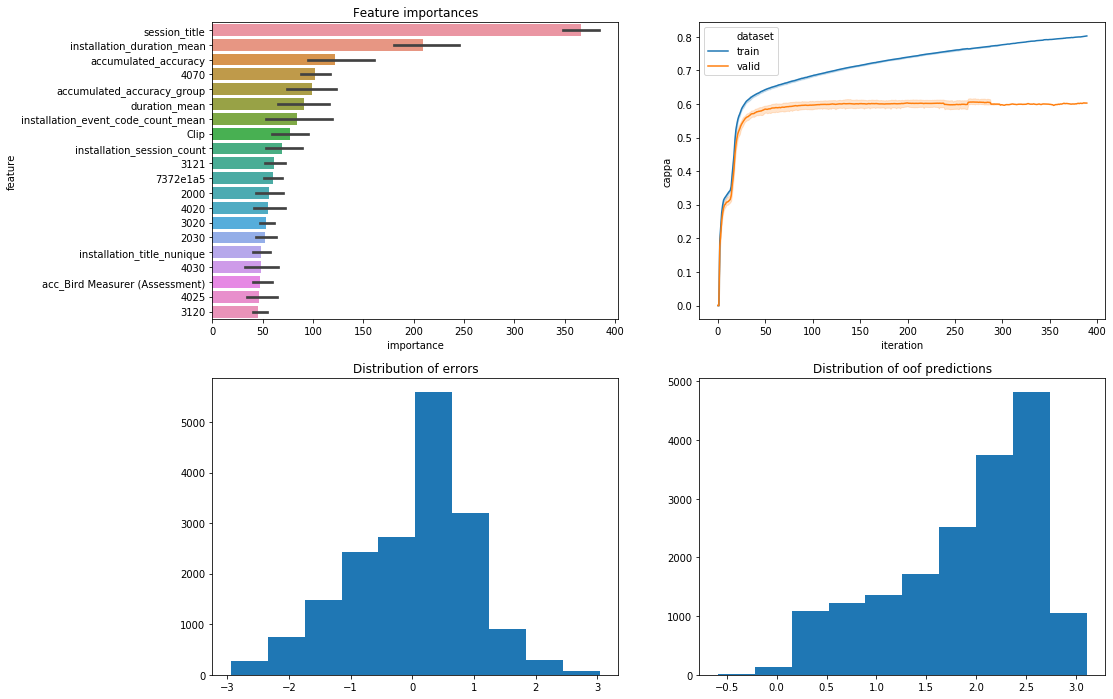

In [27]:
mt = MainTransformer()
ft = FeatureTransformer()
transformers = {'ft': ft}
regressor_model1 = RegressorModel(model_wrapper=LGBWrapper_regr())
regressor_model1.fit(X=comp_train_df, y=y, folds=folds, params=params, preprocesser=mt, transformers=transformers,
                    eval_metric='cappa', cols_to_drop=cols_to_drop)

## Inference

In [28]:
from functools import partial
import scipy as sp
class OptimizedRounder(object):
    """
    An optimizer for rounding thresholds
    to maximize Quadratic Weighted Kappa (QWK) score
    # https://www.kaggle.com/naveenasaithambi/optimizedrounder-improved
    """
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        """
        Get loss according to
        using current coefficients
        
        :param coef: A list of coefficients that will be used for rounding
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        X_p = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])

        return -qwk(y, X_p)

    def fit(self, X, y):
        """
        Optimize rounding thresholds
        
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        """
        Make predictions with specified thresholds
        
        :param X: The raw predictions
        :param coef: A list of coefficients that will be used for rounding
        """
        return pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])


    def coefficients(self):
        """
        Return the optimized coefficients
        """
        return self.coef_['x']

## Inference

In [30]:
%%time
pr1 = regressor_model1.predict(comp_train_df)

optR = OptimizedRounder()
optR.fit(pr1.reshape(-1,), y)
coefficients = optR.coefficients()

CPU times: user 18.1 s, sys: 897 ms, total: 19 s
Wall time: 4.59 s


In [31]:
opt_preds = optR.predict(pr1.reshape(-1, ), coefficients)
qwk(y, opt_preds)

0.7194083039943759

In [32]:
pr1 = regressor_model1.predict(comp_test_df)
pr1[pr1 <= 1.12232214] = 0
pr1[np.where(np.logical_and(pr1 > 1.12232214, pr1 <= 1.73925866))] = 1
pr1[np.where(np.logical_and(pr1 > 1.73925866, pr1 <= 2.22506454))] = 2
pr1[pr1 > 2.22506454] = 3

In [34]:
sample_submission_df = pd.read_csv(path/'sample_submission.csv')

In [35]:
sample_submission_df['accuracy_group'] = pr1.astype(int)
sample_submission_df.to_csv('submission.csv', index=False)

In [37]:
sample_submission_df['accuracy_group'].value_counts(normalize=True)

3    0.340
2    0.306
1    0.177
0    0.177
Name: accuracy_group, dtype: float64

In [38]:
sample_submission_df.to_csv('submission.csv', index = False)

In [39]:
!head submission.csv

installation_id,accuracy_group
00abaee7,3
01242218,3
017c5718,3
01a44906,3
01bc6cb6,3
02256298,3
0267757a,2
027e7ce5,2
02a29f99,0
